In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np

goldPriceData = pd.read_csv('/content/drive/MyDrive/FINAL_USO.csv')

goldPriceData = goldPriceData.drop_duplicates()




# Problem Statement Definition
Develop a predictive model for gold price forecasting by leveraging historical gold price data. By utilising the  recurrent neural network (RNN), long short-term memory (LSTM) networks to capture temporal dependencies and trends.

# Target Varible Identification

For this project, the target variable is the future price of gold. This variable represents the closing price of each day and the model will aim to predict this based on historic data.

# Chosing the best model

When considering what model to use for this project we decided it would have to be between a long short term model (LSTM) or a Convolutional Neural Network (CNN) to predict the daily closing price of gold. LSTM is the more suitable option as of its specialized nature which excels in sequential data processing which is applies to this use. One of  a LSTM advantage is its ability to better capture longer term dependencies within the data, which is essential for modelling the complex and evolving patterns inherent in gold prices. This is because they use memory cells which are designed to retain information over extended time including, historic data trends and relationships. LSTM’s ability to handle sequences of any length is great for time series data such as gold prices.

On the flip side, CNNs excel in tasks such as image recognition by automatically extracting relevant features similar to LSTM however, they are less adept at capturing the sequential nature of time series data which is specifically needed for this task. CNNs are primarily designed for grid like data, where spatial relationships between data points are crucial, unlike the sequential data used for this task. This limitation makes CNNs inadequate for this task and would likely return worse results. Furthermore, CNNs lack the long term memory capabilities inherent in LSTM networks, making them less effective at encoding past information and capturing complex temporal relationships.

In conclusion, for the assignment of predicting the daily price of gold using historic data, LSTM is the preferred choice due to its sequential processing capabilities and ability to capture long term dependencies. By leveraging its strengths, LSTM can effectively model the intricate dynamics of stock prices, making it a more suitable option compared to CNNs for this specific task.


In [ ]:
goldPriceData['Close'].hist()

NameError: name 'goldPriceData' is not defined

In [ ]:
targetVariables = goldPriceData[['Date', 'Close']]
targetVariables

,Date,Close
0,2011-12-15,152.330002
1,2011-12-16,155.229996
2,2011-12-19,154.869995
3,2011-12-20,156.979996
4,2011-12-21,157.160004
...,...,...
1713,2018-12-24,120.019997
1714,2018-12-26,119.660004
1715,2018-12-27,120.570000
1716,2018-12-28,121.059998


In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

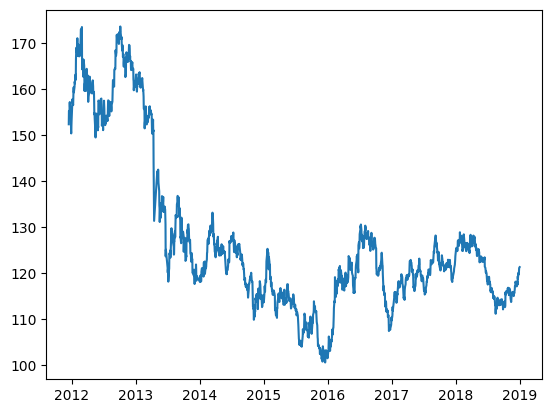

In [ ]:
import matplotlib.pyplot as plt
date = goldPriceData['Date']
date = pd.to_datetime(date)
close = goldPriceData['Close']
plt.plot(date, close)


In [ ]:
from copy import deepcopy as dc
#get closing price for 7 days before for training data
def prepareDataFrame(dataFrame, lookback=7):
  dataFrame = dc(dataFrame)

  dataFrame.set_index('Date', inplace=True)

  for i in range(1, lookback+1):
    dataFrame[f'Close(t-{i})'] = dataFrame['Close'].shift(i)

  dataFrame.dropna(inplace=True)

  return dataFrame

dataFrame = prepareDataFrame(targetVariables)
dataFrame

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2011-12-27,154.910004,156.309998,156.039993,157.160004,156.979996,154.869995,155.229996,152.330002
2011-12-28,151.029999,154.910004,156.309998,156.039993,157.160004,156.979996,154.869995,155.229996
2011-12-29,150.339996,151.029999,154.910004,156.309998,156.039993,157.160004,156.979996,154.869995
2011-12-30,151.990005,150.339996,151.029999,154.910004,156.309998,156.039993,157.160004,156.979996
2012-01-03,155.919998,151.990005,150.339996,151.029999,154.910004,156.309998,156.039993,157.160004
...,...,...,...,...,...,...,...,...
2018-12-24,120.019997,118.720001,119.239998,117.430000,118.150002,117.870003,117.059998,117.529999
2018-12-26,119.660004,120.019997,118.720001,119.239998,117.430000,118.150002,117.870003,117.059998
2018-12-27,120.570000,119.660004,120.019997,118.720001,119.239998,117.430000,118.150002,117.870003


In [ ]:
dataFrameNumpy = dataFrame.to_numpy() #shift data into numpy array
dataFrameNumpy

array([[154.910004, 156.309998, 156.039993, ..., 154.869995, 155.229996,
        152.330002],
       [151.029999, 154.910004, 156.309998, ..., 156.979996, 154.869995,
        155.229996],
       [150.339996, 151.029999, 154.910004, ..., 157.160004, 156.979996,
        154.869995],
       ...,
       [120.57    , 119.660004, 120.019997, ..., 117.43    , 118.150002,
        117.870003],
       [121.059998, 120.57    , 119.660004, ..., 119.239998, 117.43    ,
        118.150002],
       [121.25    , 121.059998, 120.57    , ..., 118.720001, 119.239998,
        117.43    ]])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1)) #scale Data
dataFrameNumpy = scaler.fit_transform(dataFrameNumpy)
dataFrameNumpy

array([[ 0.48844216,  0.52674045,  0.51935419, ...,  0.48734767,
         0.49719588,  0.41786353],
       [ 0.3823006 ,  0.48844216,  0.52674045, ...,  0.54506894,
         0.48734767,  0.49719588],
       [ 0.36342485,  0.3823006 ,  0.48844216, ...,  0.54999325,
         0.54506894,  0.48734767],
       ...,
       [-0.45096431, -0.47585819, -0.46601021, ..., -0.53686227,
        -0.51716587, -0.52482553],
       [-0.4375599 , -0.45096431, -0.47585819, ..., -0.48734789,
        -0.53686227, -0.51716587],
       [-0.4323622 , -0.4375599 , -0.45096431, ..., -0.50157295,
        -0.48734789, -0.53686227]])

In [ ]:
# get X and Y Values

X = dataFrameNumpy[:, 1:]
Y= dataFrameNumpy[:, 0]
X.shape, Y.shape

((1711, 7), (1711,))

In [ ]:
split_index = int(len(X) * 0.90) #get train and test split
split_index

1539

In [ ]:
X_train = X[:split_index]
X_test = X[split_index:]

Y_train = Y[:split_index]
Y_test = Y[split_index:]
# add extra dimension becuase pytorch requires
X_train = X_train.reshape((-1, 7, 1))
X_test = X_test.reshape((-1, 7, 1))

Y_train = Y_train.reshape((-1,1))
Y_test = Y_test.reshape((-1,1))


X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1539, 7, 1), (172, 7, 1), (1539, 1), (172, 1))

In [ ]:
#Convert into Tensors

X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
Y_train = torch.tensor(Y_train).float()
Y_test = torch.tensor(Y_test).float()

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

(torch.Size([1539, 7, 1]),
 torch.Size([172, 7, 1]),
 torch.Size([1539, 1]),
 torch.Size([172, 1]))

In [ ]:
from torch.utils.data import Dataset

#make a dataset with tensors
class TensorDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.Y[i]

train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

In [ ]:
from torch.utils.data import DataLoader
#Get Data in batches
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(x_batch.shape, y_batch.shape)
  break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [ ]:
##Build neural network LSTM

class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out
model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:

def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [ ]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [ ]:
#Train Model
learning_rate = 0.001
epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
  train_one_epoch()
  validate_one_epoch()

Epoch: 1

Val Loss: 0.124
***************************************************

Epoch: 2

Val Loss: 0.043
***************************************************

Epoch: 3

Val Loss: 0.008
***************************************************

Epoch: 4

Val Loss: 0.001
***************************************************

Epoch: 5

Val Loss: 0.002
***************************************************

Epoch: 6

Val Loss: 0.001
***************************************************

Epoch: 7

Val Loss: 0.001
***************************************************

Epoch: 8

Val Loss: 0.001
***************************************************

Epoch: 9

Val Loss: 0.002
***************************************************

Epoch: 10

Val Loss: 0.001
***************************************************



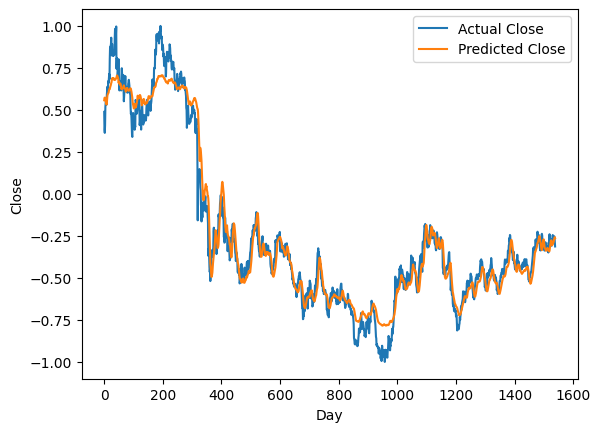

In [ ]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(Y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [5]:
#@title User Interface Prediction

Days = 0 # @param {type:"integer"}

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/FINAL_USO.csv'